# Churn Prediction for Retail Banking Scenario

<h3><span style="color: #117d30;"> Exploratory Data Analysis, Feature Engineering, ML Model Training and Prediction in Fabric</span></h3>


## Disclaimer

By accessing this code, you acknowledge the code is made available for presentation and demonstration purposes only and that the code (1) is not subject to SOC 1 and SOC 2 compliance audits, and (2) is not designed or intended to be a substitute for the professional advice, diagnosis, treatment, or judgment of a certified financial services professional. Do not use this code to replace, substitute, or provide professional financial advice, or judgement. You are solely responsible for ensuring the regulatory, legal, and/or contractual compliance of any use of the code, including obtaining any authorizations or consents, and any solution you choose to build that incorporates this code in whole or in part.

© 2024 Microsoft Corporation. All rights reserved

### Introduction
In this example we show how to do Exploratory Data Analysis, Data Preparation and Feature Engineering for a dataset describing customer churn for a retail bank. At the end of this notebook we will register this dataset in Azure ML and use it in the next few notebooks to run predictive models using Azure's AutoML.

In [ ]:
!pip install --upgrade azure-storage-blob --quiet
!pip install azureml-core --quiet
!pip install -U yellowbrick --quiet

### Importing required libraries

In [2]:
import mlflow
import logging  
import warnings
import numpy as np
import yellowbrick
import pandas as pd 
import seaborn as sns
from flaml import AutoML
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
from yellowbrick.classifier import ROCAUC
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import isnan, when, col
from flaml.automl.spark.utils import to_pandas_on_spark
from sklearn.metrics import roc_curve, auc, roc_auc_score
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
logging.getLogger('matplotlib.font_manager').disabled = True

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 4, Finished, Available, Finished)

### Loading the dataset

In [3]:
df = spark.read.format("csv").option("header","true").option('inferSchema', "true").load("Files/churn_data/retail_banking_customer_churn_data.csv")
display(df)

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 5, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, ed5c7131-a149-42b4-aeb8-d01158078607)

## 1. Exploratory data analysis

#### Data Analysis and  visualization

At the outset of our data analysis, we will explore the dataset thoroughly. This includes identifying any gaps in the data and understanding the data types of each variable. This will help us spot initial trends, key characteristics, and interesting data points. We will also construct data visualizations, which will provide us with more insights into our dataset and inform the best approach for building our predictive model.

In [4]:
# Renaming the Churn column
data = df.withColumnRenamed("y", "churn")

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 6, Finished, Available, Finished)

##### The first plot is to look at the customer's age density. This will show us the distribution of our customers age.

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 7, Finished, Available, Finished)

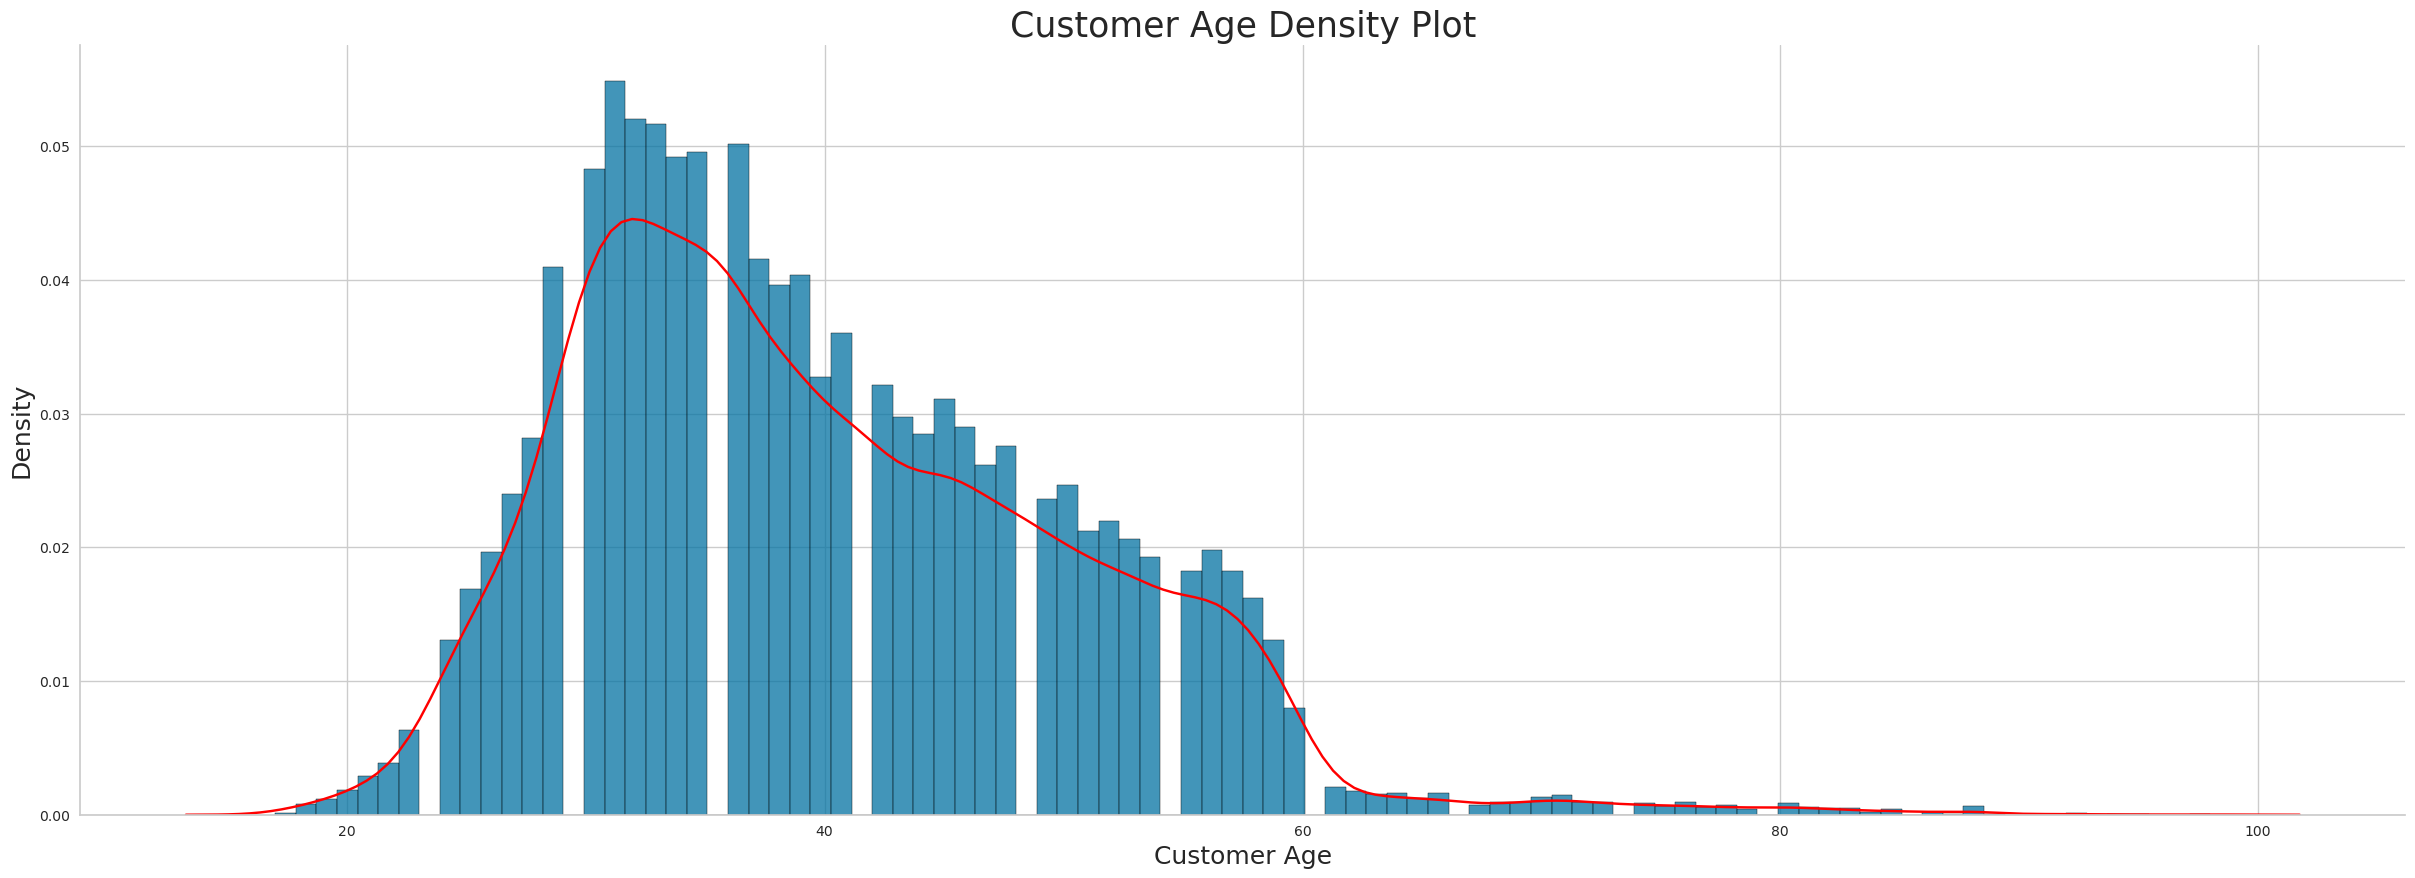

In [5]:
plt.figure(figsize=(30,10))
age_series = data.select('age').toPandas()['age']
age_series_numeric = pd.to_numeric(age_series, errors='coerce')
ax = sns.histplot(age_series, palette='Blues', stat='density',legend=True) #Histogram for customer age
sns.kdeplot(age_series_numeric, color='red',legend=True) #Density plot
sns.despine() #removing top and right borders
ax.set_title('Customer Age Density Plot',fontsize=25)
ax.set_xlabel('Customer Age', fontsize=18)
ax.set_ylabel('Density', fontsize=18)
plt.show()

##### This chart makes it easy to see how many customers churned (left) and how many didn't churn (stayed).

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 8, Finished, Available, Finished)

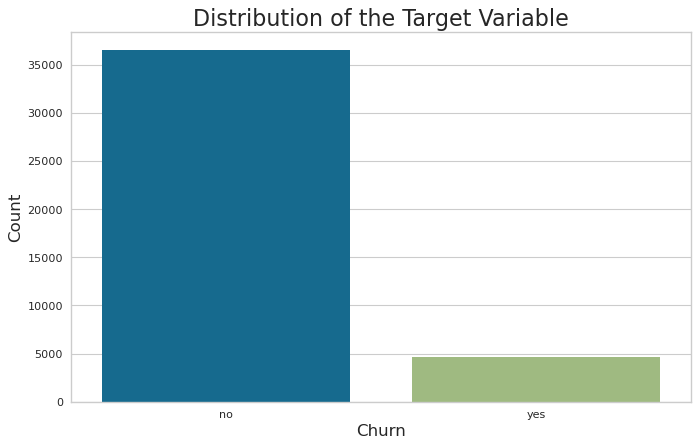

In [6]:
# Perform the aggregation
churn_counts = data.groupBy("churn").count().orderBy("churn")

# Collect the data to the driver node
churn_counts_df = churn_counts.toPandas()

# Plot the data
fig = plt.figure(figsize=(10, 6), dpi=80)
ax = sns.barplot(x="churn", y="count", data=churn_counts_df)
ax.set_title('Distribution of the Target Variable', fontsize=20)
ax.set_xlabel('Churn', fontsize=15)
ax.set_ylabel('Count', fontsize=15)

plt.show()

### Customer Retention Analysis
The following graph shows the customer retention based on demographic data columns like Age and Profession, Age and Education, Age and Housing.

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 9, Finished, Available, Finished)

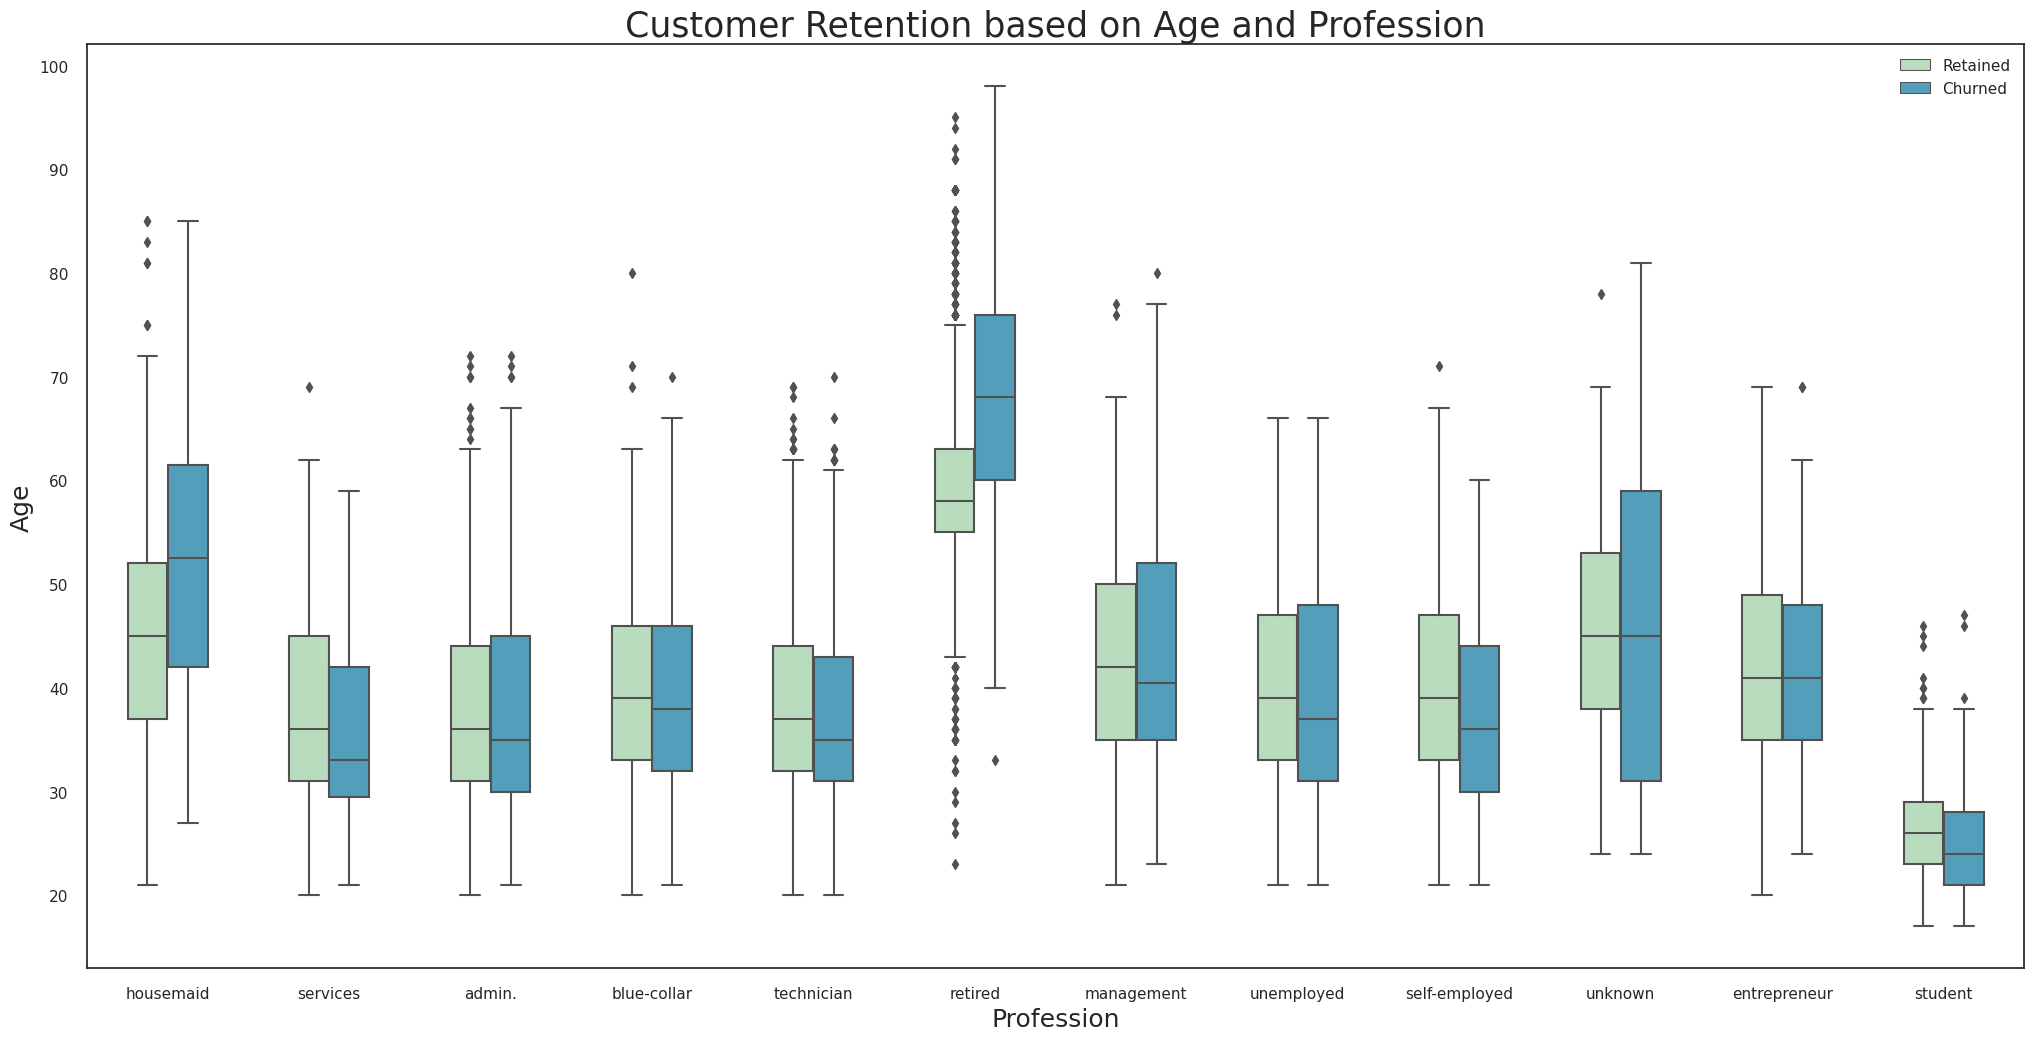

In [7]:
# Customer Retention Based on Age and Profession
sns.set(style="white") #Making background white
plt.figure(figsize=(25,12)) #Setting figure size
data_pd = data.toPandas()
data_pd['age'] = pd.to_numeric(data_pd['age'], errors='coerce')
ax = sns.boxplot(x="job", y="age", hue="churn", data=data_pd, palette="GnBu", width=0.5) #Creating boxplot and setting color palette
handles, _= ax.get_legend_handles_labels()#Changing legend
ax.legend(handles, ["Retained", "Churned"])
ax.set_title('Customer Retention based on Age and Profession',fontsize=25)
ax.set_xlabel('Profession', fontsize=18)
ax.set_ylabel('Age', fontsize=18)
plt.show()

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 10, Finished, Available, Finished)

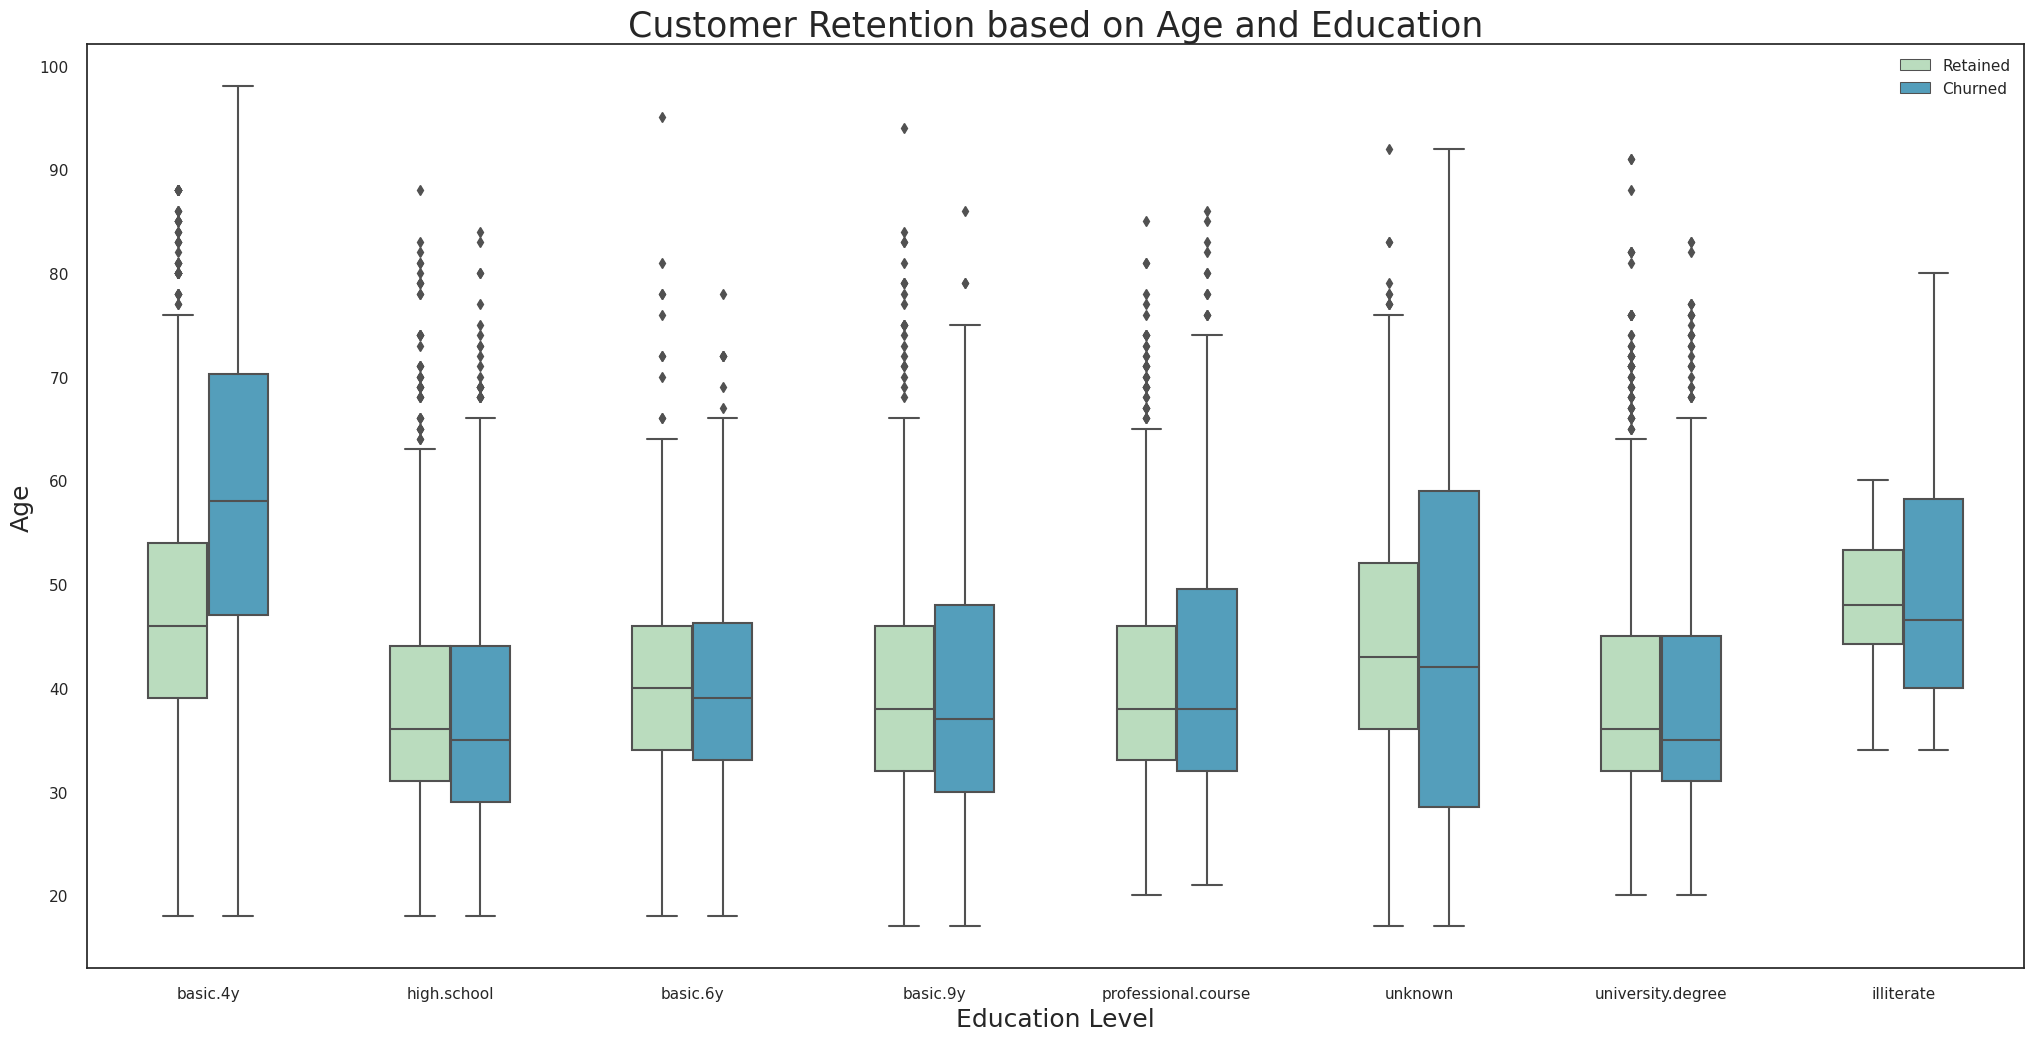

In [8]:
# Customer Retention Based on Age and Education
sns.set(style="white")
plt.figure(figsize=(25,12))
ax = sns.boxplot(x="education", y='age', hue="churn", data=data_pd, palette="GnBu", width=0.5)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Retained", "Churned"])
ax.set_title('Customer Retention based on Age and Education',fontsize=25)
ax.set_xlabel('Education Level', fontsize=18)
ax.set_ylabel('Age', fontsize=18)
plt.show()

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 11, Finished, Available, Finished)

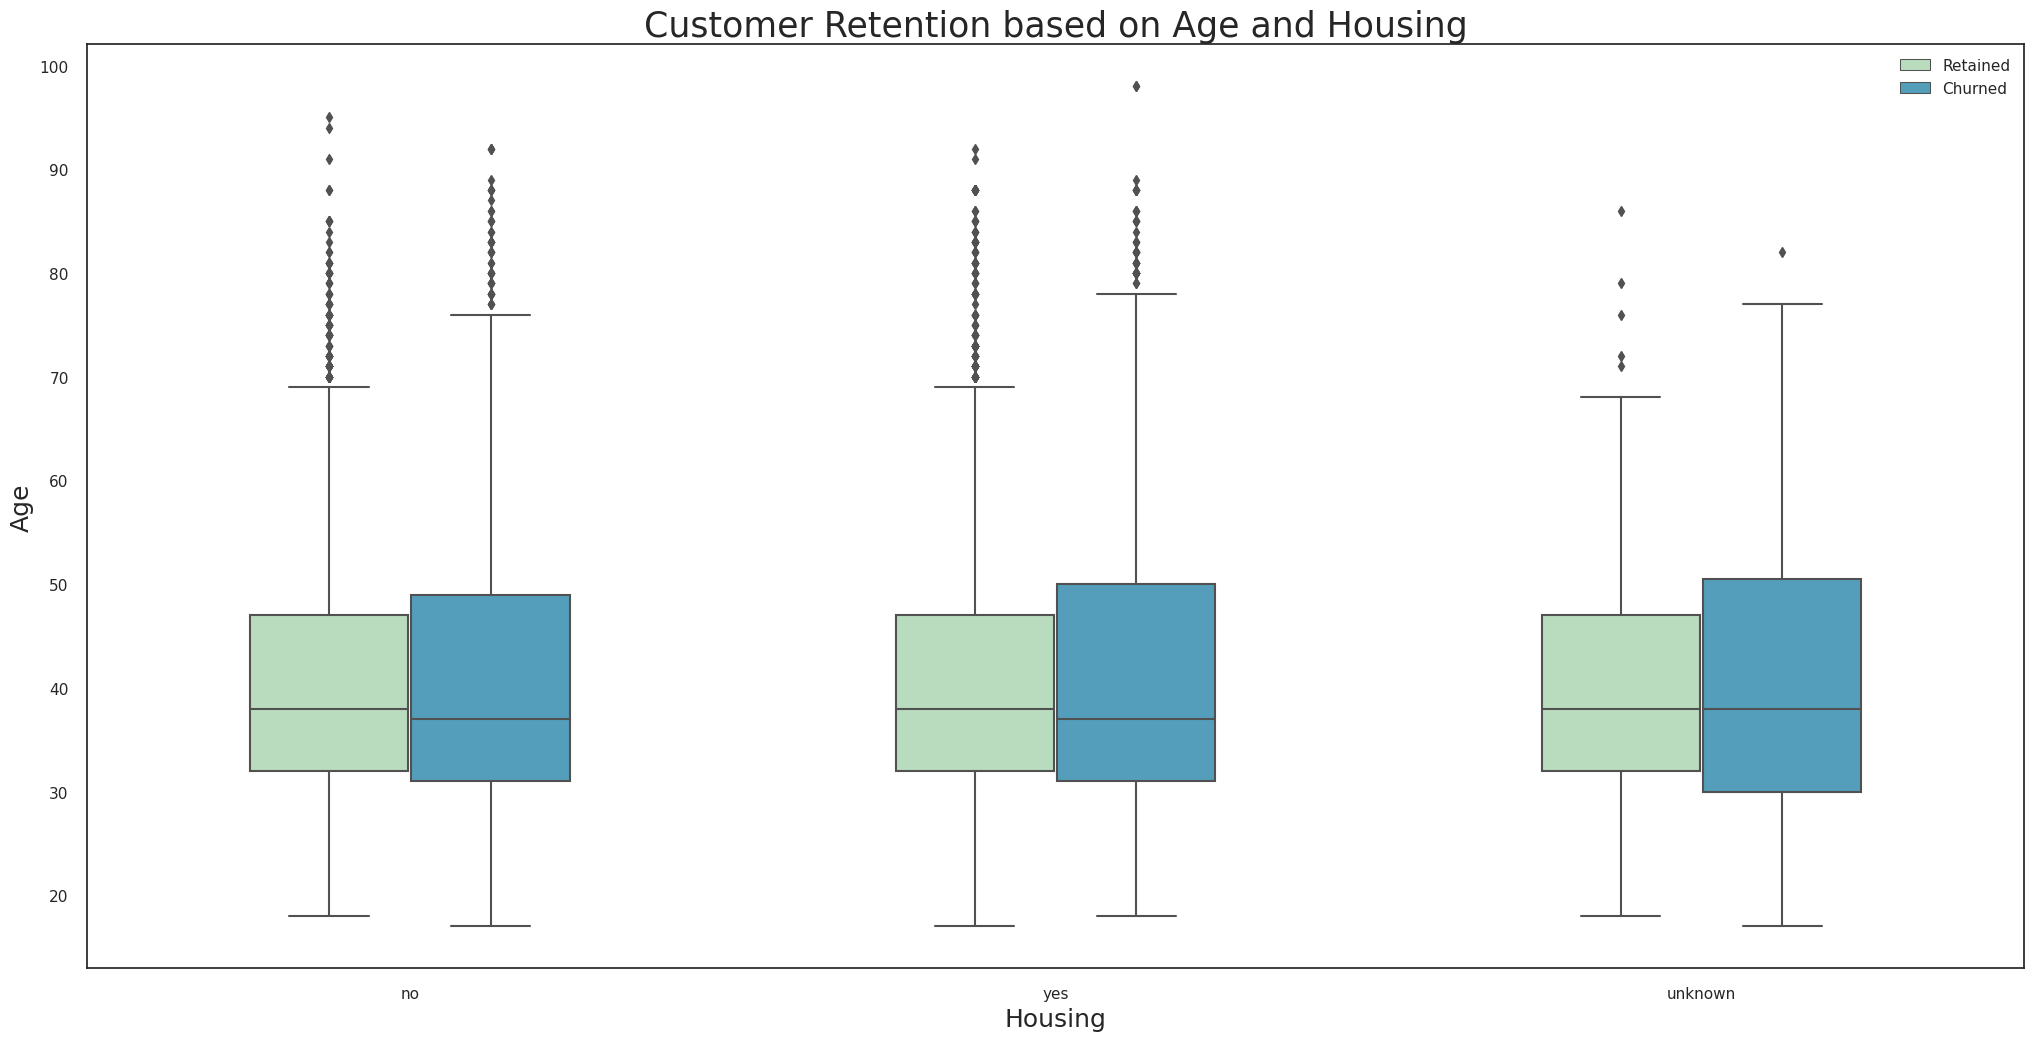

In [9]:
# Customer Retention Based on Age and Housing
sns.set(style="white")
plt.figure(figsize=(25,12))
ax = sns.boxplot(x="housing", y='age', hue="churn", data=data_pd, palette="GnBu", width=0.5)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["Retained", "Churned"])
ax.set_title('Customer Retention based on Age and Housing',fontsize=25)
ax.set_xlabel('Housing', fontsize=18)
ax.set_ylabel('Age', fontsize=18)
plt.show()

### Categorical Distributions

The following graphs use different features (categories) to segment our customers.  We do this to see if we can find anything insightful or meaningful before we build our model(s).

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 12, Finished, Available, Finished)

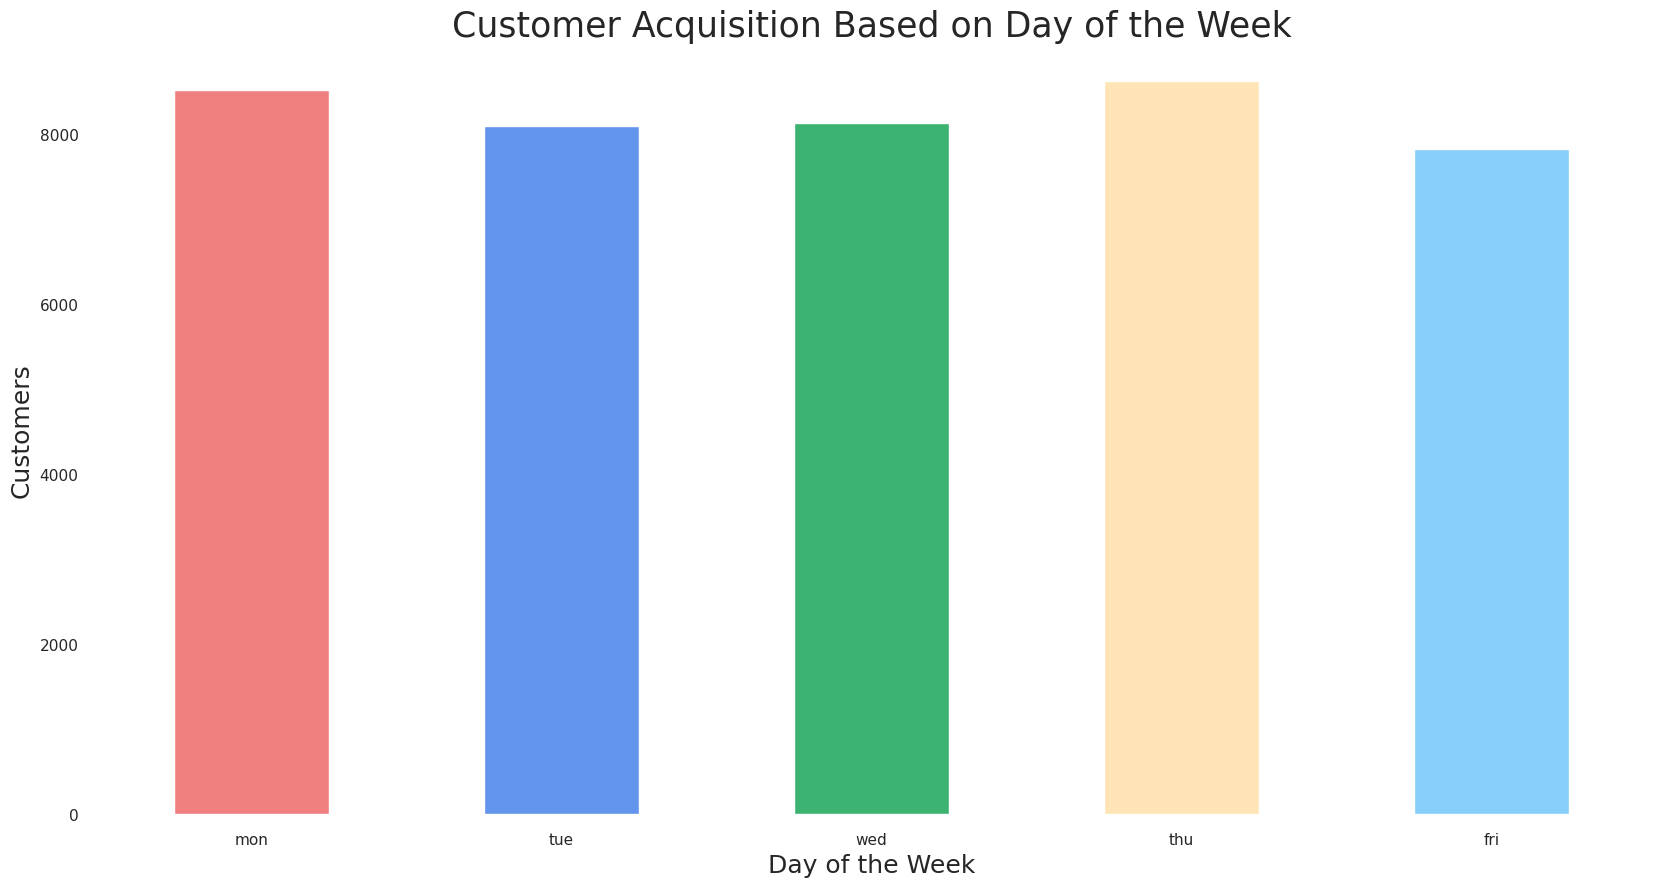

In [10]:
# This graph breaks represents what day of the week customers were acquiried on.
days = ["mon", "tue", "wed", "thu", "fri"] #Create list for days of the week.  This will be x-axis
data_pd['day_of_week'] = pd.Categorical(data_pd.day_of_week, categories=days, ordered=True)
plt.figure(figsize=(20,10))
GroupedData=data_pd.groupby(by='day_of_week').size() #Group data by value
sns.despine()
colors = ['lightcoral','cornflowerblue','mediumseagreen','moccasin', 'lightskyblue', 'plum', 'lightgray', 'khaki'] #Set color palette
ax = GroupedData.plot.bar(color=colors) #Plot values in a bar chart
sns.despine(left=True, bottom=True)
ax.set_title('Customer Acquisition Based on Day of the Week',fontsize=25)
ax.set_xlabel('Day of the Week', fontsize=18)
ax.set_ylabel('Customers', fontsize=18)

plt.xticks(rotation=0) #Make bar chart vertical
plt.show()

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 13, Finished, Available, Finished)

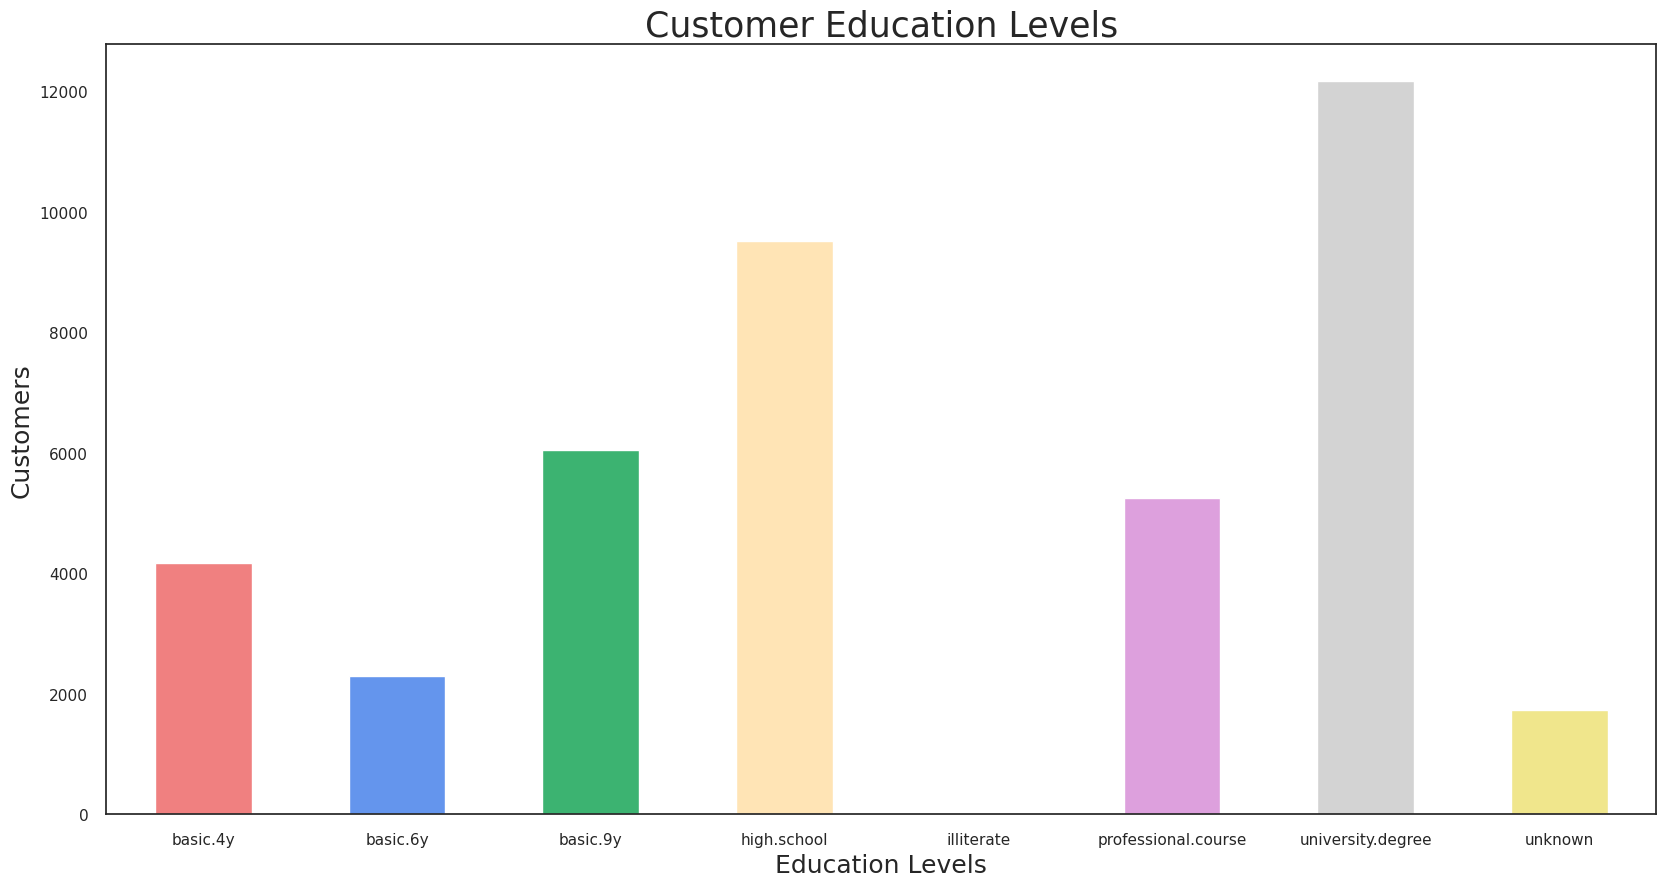

In [11]:
# Education distribution

plt.figure(figsize=(20,10))#figure size
sns.despine()

GroupedData=data_pd.groupby(by='education').size()#grouping values
sns.despine(left=True,bottom=True)
colors = ['lightcoral','cornflowerblue','mediumseagreen','moccasin','lightskyblue','plum','lightgray','khaki']#color palette
ax = GroupedData.plot.bar(color=colors)#plotting bar chart
ax.set_title('Customer Education Levels',fontsize=25)
ax.set_xlabel('Education Levels', fontsize=18)
ax.set_ylabel('Customers', fontsize=18)

plt.xticks(rotation=0)
plt.show()

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 14, Finished, Available, Finished)

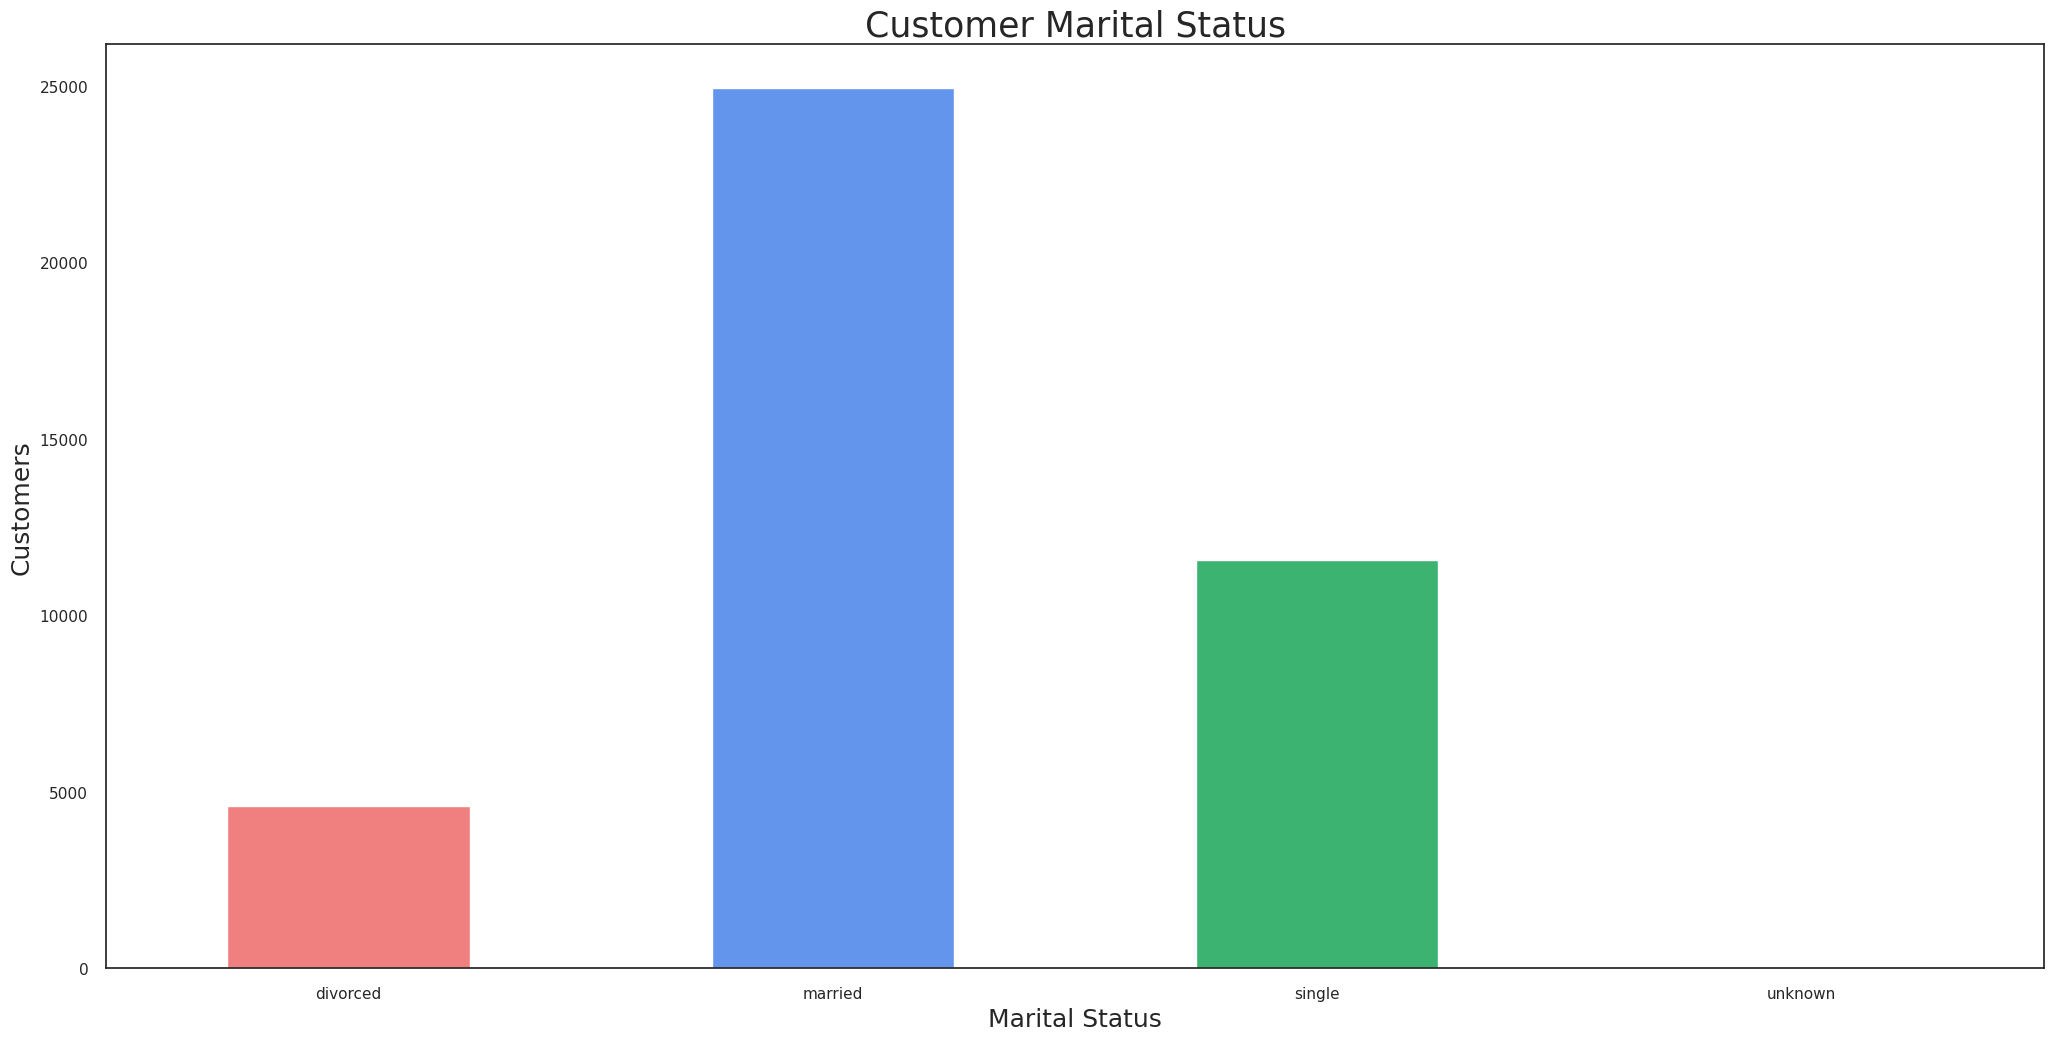

In [12]:
# Marital Status distribution
plt.figure(figsize=(25,12)) #figure size
sns.despine()
colors = ['lightcoral','cornflowerblue','mediumseagreen','moccasin','lightskyblue','plum','lightgray','khaki']#color palette
GroupedData=data_pd.groupby(by='marital').size() #grouping by values
sns.despine(left=True,bottom=True)
ax = GroupedData.plot.bar(color=colors) #make bar chart
ax.set_title('Customer Marital Status',fontsize=25)
ax.set_xlabel('Marital Status', fontsize=18)
ax.set_ylabel('Customers', fontsize=18)
plt.xticks(rotation=0)
plt.show() #display bar chart

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 15, Finished, Available, Finished)

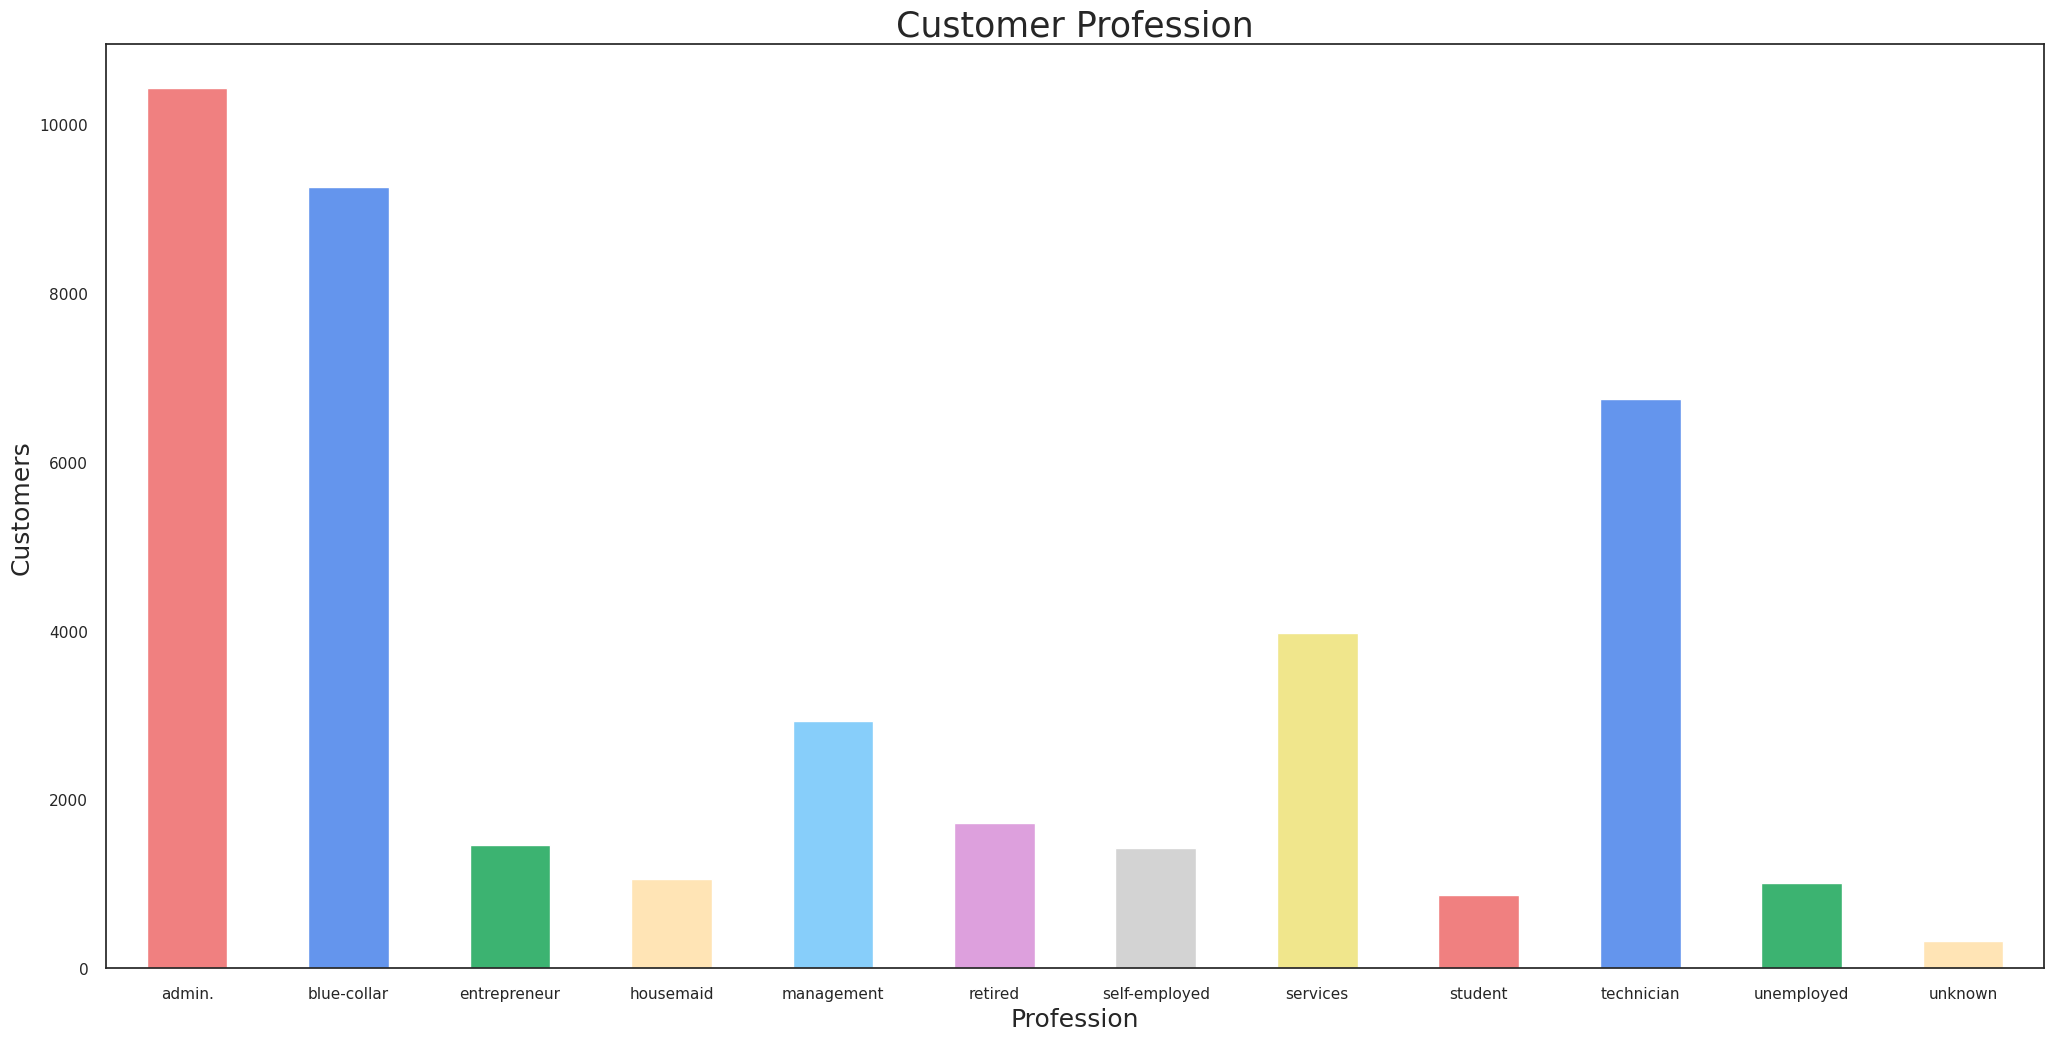

In [13]:
# Job level distribution

plt.figure(figsize=(25,12)) #graph size
sns.despine()
colors = ['lightcoral','cornflowerblue','mediumseagreen','moccasin','lightskyblue','plum','lightgray','khaki'] #colors
GroupedData=data_pd.groupby(by='job').size() #grouping by values
sns.despine(left=True,bottom=True)
ax = GroupedData.plot.bar(color=colors) #plotting grouped values
ax.set_title('Customer Profession',fontsize=25)
ax.set_xlabel('Profession', fontsize=18)
ax.set_ylabel('Customers', fontsize=18)

plt.xticks(rotation=0)
plt.show() #displaying chart


### Correlation matrix

We use a correlation matrix to find relationships between numerical variables.  This helps us decide which variables to keep and which to eliminate before we build our model(s).

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 16, Finished, Available, Finished)

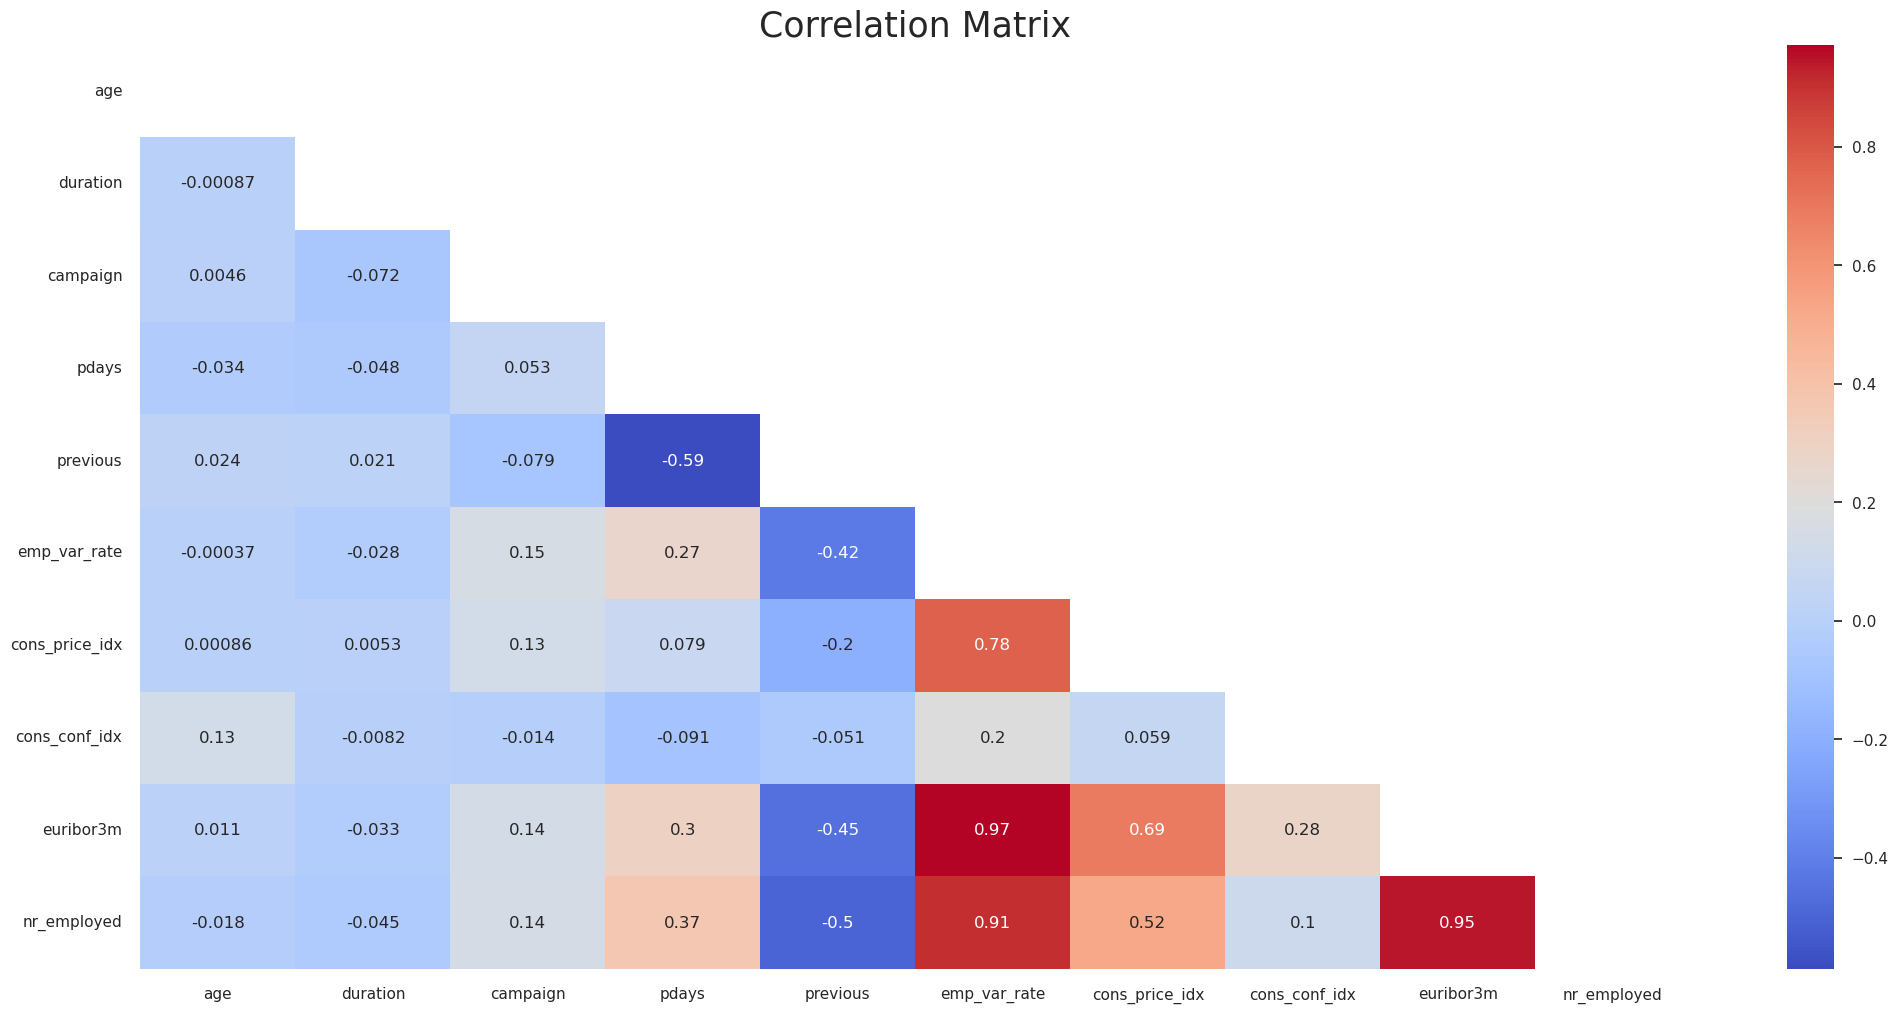

In [14]:
# Numerical columns correlation matrix
sns.set(style="white") #background color
plt.subplots(figsize=(25,12)) #graph size

# Select only numeric columns for correlation calculation
numeric_columns = data_pd.select_dtypes(include=np.number)
matrix = np.triu(numeric_columns.corr()) #build matrix
ax = sns.heatmap(numeric_columns.corr(), annot=True, mask=matrix, cmap= 'coolwarm') #create heatmap and choose color palette
ax.set_title('Correlation Matrix', fontsize=25) #title
plt.show() #show matrix

We're changing 'yes' and 'no' in the 'churn' column to 1 and 0 respectively, to make visualizing the data easier.

In [15]:
# Convert binary variable into numeric to make visualisation easier
from pyspark.sql import functions as F
data = data.withColumn('churn', F.when(data['churn'] == 'yes', 1).otherwise(0))
display(data)

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 17, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, b03056f5-ee9e-4ea0-b854-39f454ab9f1b)

### Customer Churn

These remaining charts look at customer churn based on a single feature. This will tell us if a certain feature is making it more likely that certain customers churn.  
If there is a correlation, that will help us in predicting churn in the future.


StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 18, Finished, Available, Finished)

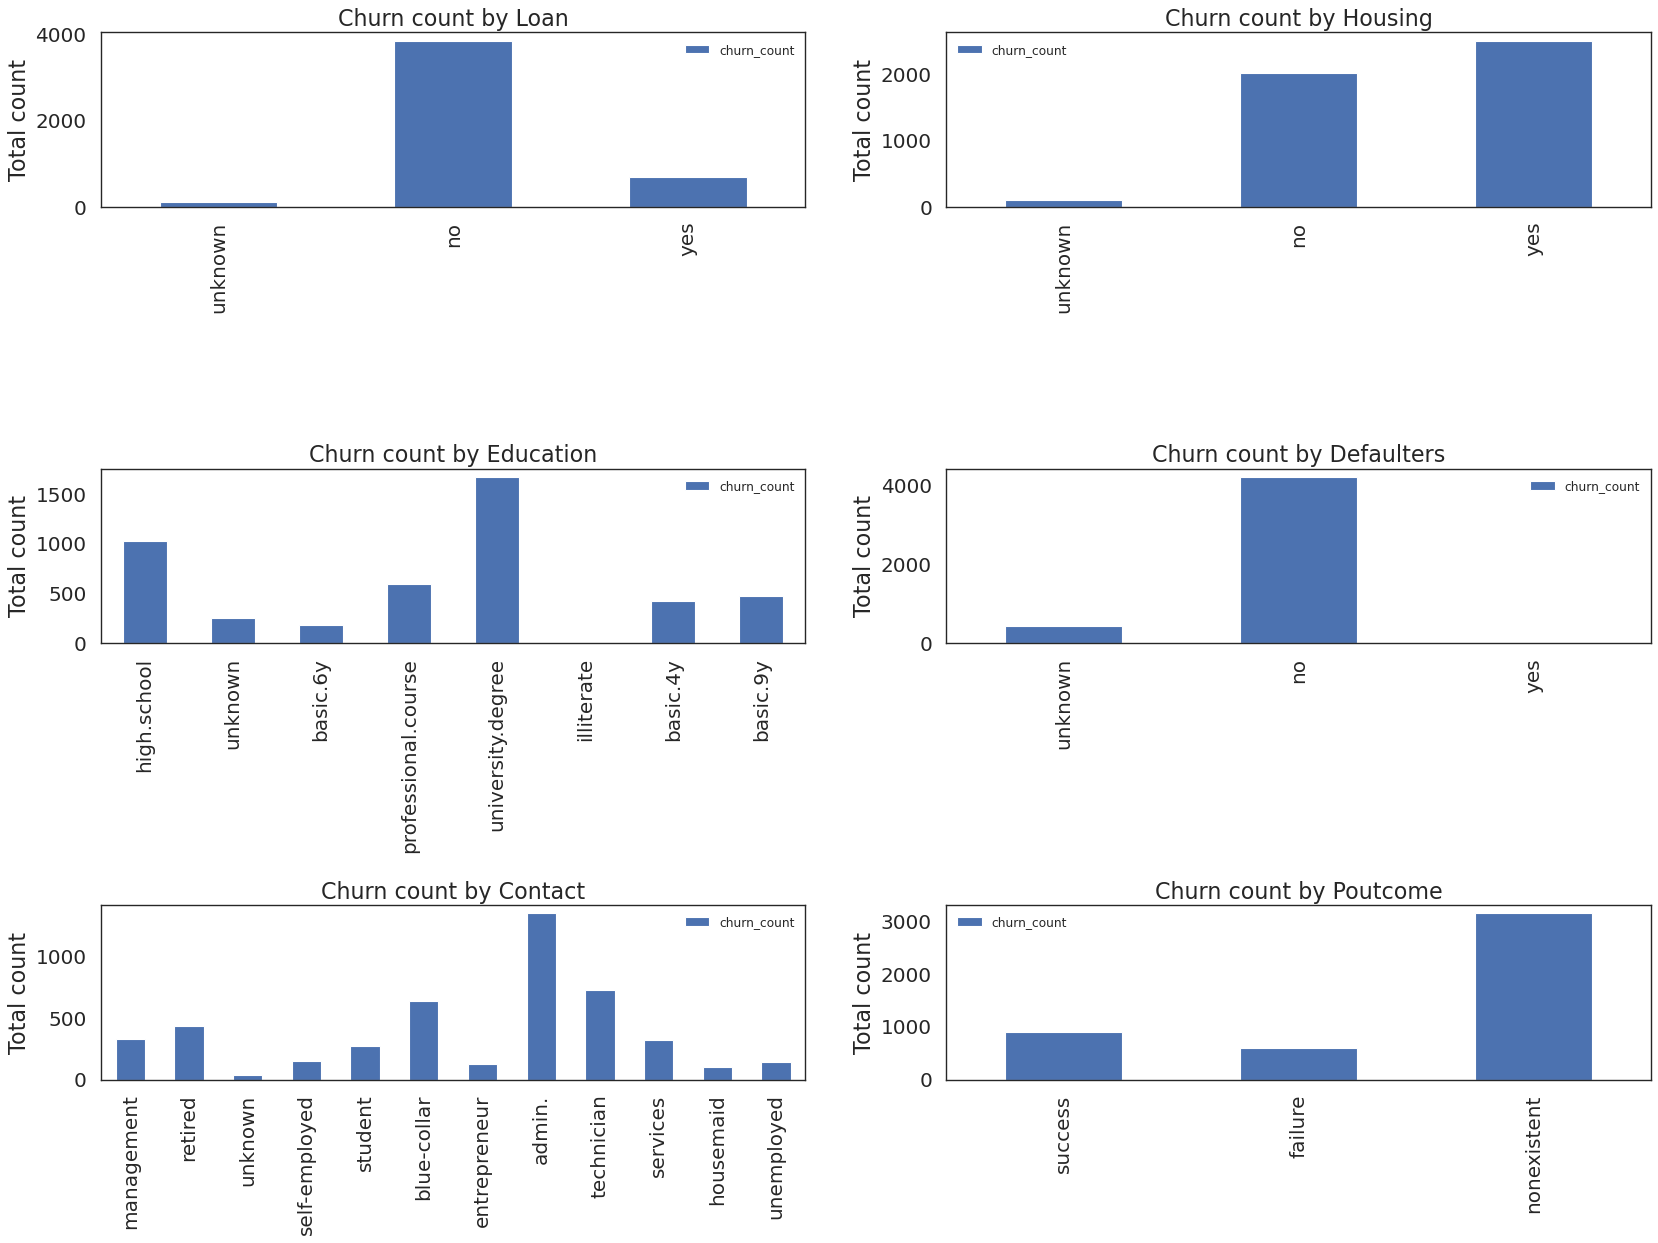

In [16]:
# Group by loan and calculate churn counts
loan_churn_counts = data.groupBy('loan').agg(F.sum('churn').alias('churn_count'))

# Group by housing and calculate churn counts
housing_churn_counts = data.groupBy('housing').agg(F.sum('churn').alias('churn_count'))

# Group by education and calculate churn counts
education_churn_counts = data.groupBy('education').agg(F.sum('churn').alias('churn_count'))

# Group by default and calculate churn counts
default_churn_counts = data.groupBy('default').agg(F.sum('churn').alias('churn_count'))

# Group by job and calculate churn counts
job_churn_counts = data.groupBy('job').agg(F.sum('churn').alias('churn_count'))

# Group by poutcome and calculate churn counts
poutcome_churn_counts = data.groupBy('poutcome').agg(F.sum('churn').alias('churn_count'))

# Create subplots
fig, ((ax1,ax2),(ax3,ax4), (ax5,ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(25,17), dpi=80)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.5)

# Plot churn count by loan
loan_churn_counts.toPandas().plot(kind='bar', x='loan', y='churn_count', ax=ax1)
ax1.set_ylabel('Total count', fontsize=20)
ax1.set_xlabel('', fontsize=20)
ax1.tick_params(labelsize=18)
ax1.set_title('Churn count by Loan', fontsize=20)

# Plot churn count by housing
housing_churn_counts.toPandas().plot(kind='bar', x='housing', y='churn_count', ax=ax2)
ax2.set_ylabel('Total count', fontsize=20)
ax2.set_xlabel('', fontsize=20)
ax2.tick_params(labelsize=18)
ax2.set_title('Churn count by Housing', fontsize=20)

# Plot churn count by education
education_churn_counts.toPandas().plot(kind='bar', x='education', y='churn_count', ax=ax3)
ax3.set_ylabel('Total count', fontsize=20)
ax3.set_xlabel('', fontsize=20)
ax3.tick_params(labelsize=18)
ax3.set_title('Churn count by Education', fontsize=20)

# Plot churn count by default
default_churn_counts.toPandas().plot(kind='bar', x='default', y='churn_count', ax=ax4)
ax4.set_ylabel('Total count', fontsize=20)
ax4.set_xlabel('', fontsize=20)
ax4.tick_params(labelsize=18)
ax4.set_title('Churn count by Defaulters', fontsize=20)

# Plot churn count by job
job_churn_counts.toPandas().plot(kind='bar', x='job', y='churn_count', ax=ax5)
ax5.set_ylabel('Total count', fontsize=20)
ax5.set_xlabel('', fontsize=20)
ax5.tick_params(labelsize=18)
ax5.set_title('Churn count by Contact', fontsize=20)

# Plot churn count by poutcome
poutcome_churn_counts.toPandas().plot(kind='bar', x='poutcome', y='churn_count', ax=ax6)
ax6.set_ylabel('Total count', fontsize=20)
ax6.set_xlabel('', fontsize=20)
ax6.tick_params(labelsize=18)
ax6.set_title('Churn count by Poutcome', fontsize=20)

plt.show()

##### Converting "unknown" values to "NAN" to make them easier to clean

In [17]:
# Replace "unknown" values with null (NaN)
data = data.replace("unknown", None)

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 19, Finished, Available, Finished)

##### Creating a visual box plot to compare the values of column "emp_var_rate" with columns "housing" and "churn".

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 20, Finished, Available, Finished)

Text(39.44531587577161, 0.5, 'emp_var_rate')

<Figure size 800x640 with 0 Axes>

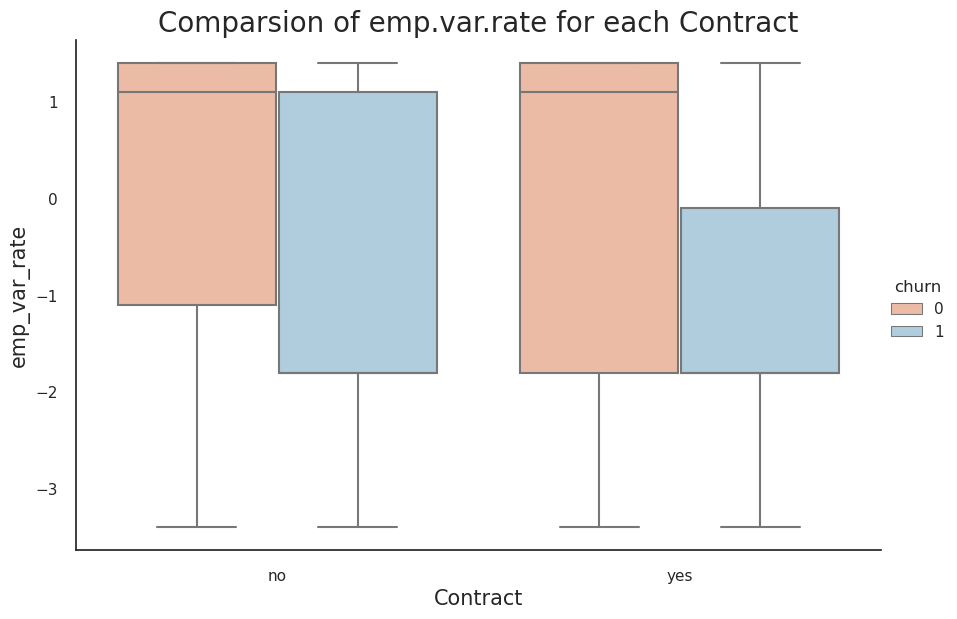

In [18]:
# Convert Spark DataFrame to Pandas DataFrame
data_pandas = data.toPandas()
data_pandas['emp_var_rate'] = data_pandas['emp_var_rate'].astype(float)
plt.figure(figsize=(10,8), dpi=80)
ax = sns.catplot(x="housing", y="emp_var_rate", hue="churn", kind="box", data=data_pandas, height = 6, aspect = 1.5, palette = 'RdBu')
plt.title('Comparsion of emp.var.rate for each Contract',fontsize = 20)
plt.xlabel('Contract',fontsize = 15)
plt.ylabel('emp_var_rate',fontsize = 15)


StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 21, Finished, Available, Finished)

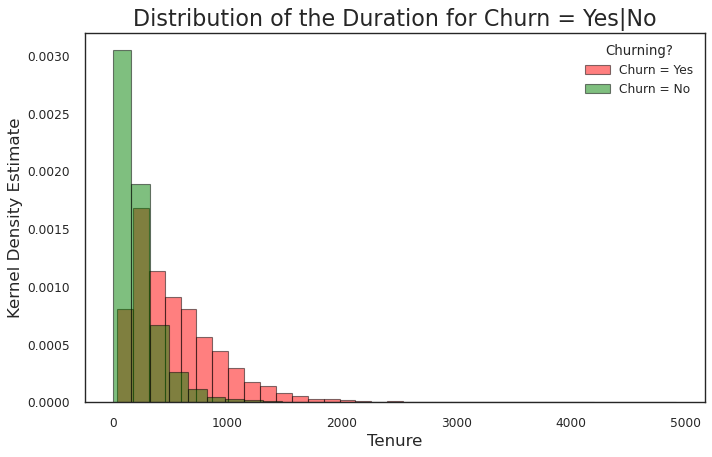

In [19]:
kde_plot_data_a = data.filter(data['churn'] == 1).select('duration').rdd.flatMap(lambda x: x).collect()
kde_plot_data_b = data.filter(data['churn'] == 0).select('duration').rdd.flatMap(lambda x: x).collect()

# Plotting using matplotlib
plt.figure(figsize=(10,6), dpi=80)
plt.hist(kde_plot_data_a, density=True, bins=30, alpha=0.5, color='red', label='Churn = Yes', edgecolor='black')
plt.hist(kde_plot_data_b, density=True, bins=30, alpha=0.5, color='green', label='Churn = No', edgecolor='black')
plt.legend(title='Churning?', loc='upper right')
plt.title('Distribution of the Duration for Churn = Yes|No', fontsize=20)
plt.xlabel('Tenure', fontsize=15)
plt.ylabel('Kernel Density Estimate', fontsize=15)
plt.show()


##### Visualising consumer price index for Churn vs non-churn customers

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 22, Finished, Available, Finished)

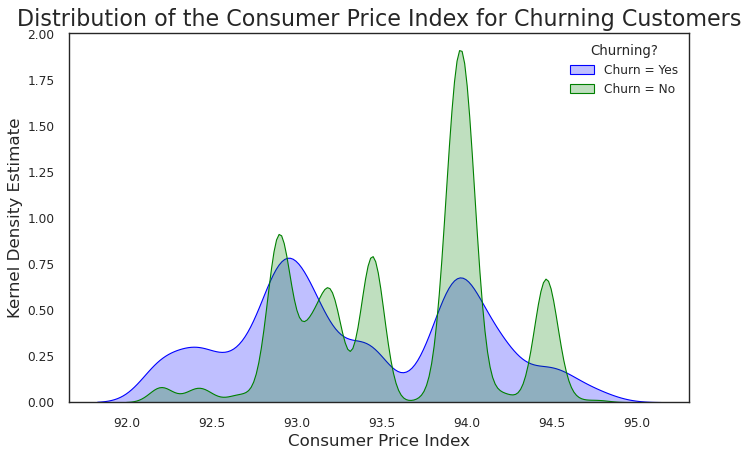

In [20]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' is your Spark DataFrame

# Filter the Spark DataFrame for churn = 1 and churn = 0
kde_plot_data_a = data.filter(data['churn'] == 1).select('cons_price_idx')
kde_plot_data_b = data.filter(data['churn'] == 0).select('cons_price_idx')

# Convert Spark DataFrame to Pandas DataFrame for plotting
kde_plot_data_a = kde_plot_data_a.toPandas()['cons_price_idx'].astype(float)
kde_plot_data_b = kde_plot_data_b.toPandas()['cons_price_idx'].astype(float)

# Plot the kernel density estimates
plt.figure(figsize=(10, 6), dpi=80)
sns.kdeplot(data=kde_plot_data_a, fill=True, color='blue', legend=False)
sns.kdeplot(data=kde_plot_data_b, fill=True, color='green', legend=False)
plt.title('Distribution of the Consumer Price Index for Churning Customers', fontsize=20)
plt.legend(title='Churning?', loc='upper right', labels=['Churn = Yes', 'Churn = No'])
plt.xlabel('Consumer Price Index', fontsize=15)
plt.ylabel('Kernel Density Estimate', fontsize=15)
plt.show()


##### Visualising employment variation rate for Churning vs non-churn customers

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 23, Finished, Available, Finished)

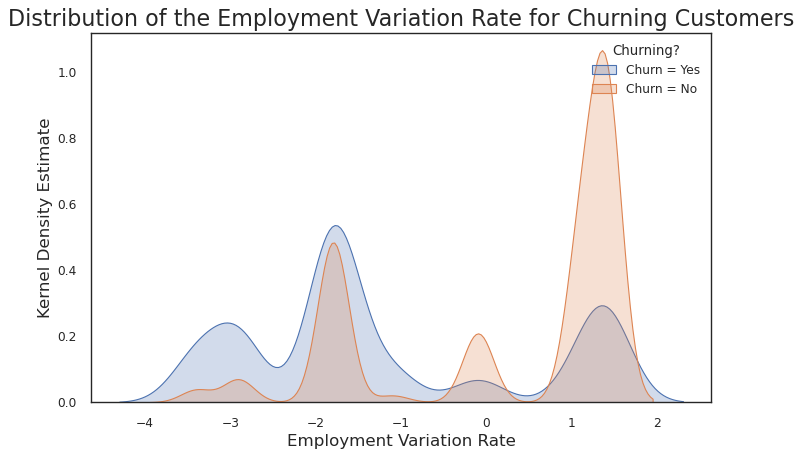

In [21]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns


# Filter the Spark DataFrame for churn = 1 and churn = 0
kde_plot_data_a = data.filter(data['churn'] == 1).select('emp_var_rate')
kde_plot_data_b = data.filter(data['churn'] == 0).select('emp_var_rate')

# Convert Spark DataFrame to Pandas DataFrame for plotting
kde_plot_data_a = kde_plot_data_a.toPandas()['emp_var_rate'].astype(float)
kde_plot_data_b = kde_plot_data_b.toPandas()['emp_var_rate'].astype(float)

# Plot the kernel density estimates
plt.figure(figsize=(10, 6), dpi=80)
sns.kdeplot(data=kde_plot_data_a, shade=True, legend=False)
sns.kdeplot(data=kde_plot_data_b, shade=True, legend=False)
plt.title('Distribution of the Employment Variation Rate for Churning Customers', fontsize=20)
plt.legend(title='Churning?', loc='upper right', labels=['Churn = Yes', 'Churn = No'])
plt.xlabel('Employment Variation Rate', fontsize=15)
plt.ylabel('Kernel Density Estimate', fontsize=15)
plt.show()

##### Visualising Euribor for Churning vs non-churn customers

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 24, Finished, Available, Finished)

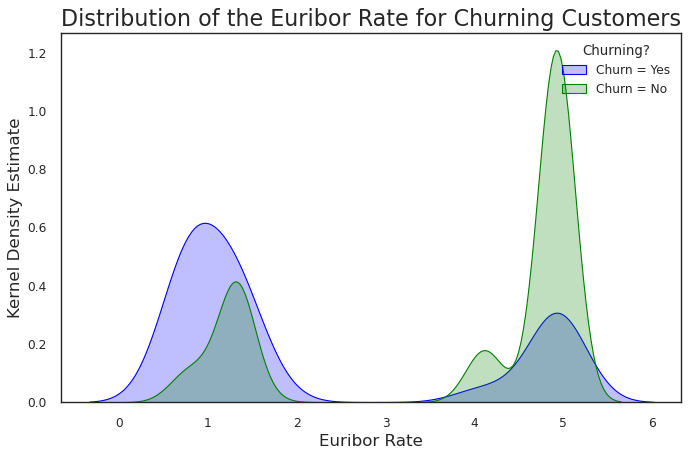

In [22]:
kde_plot_data_a = data.filter(data['churn'] == 1).select('euribor3m')
kde_plot_data_b = data.filter(data['churn'] == 0).select('euribor3m')

# Convert Spark DataFrame to Pandas DataFrame for plotting
kde_plot_data_a = kde_plot_data_a.toPandas()['euribor3m'].astype(float)
kde_plot_data_b = kde_plot_data_b.toPandas()['euribor3m'].astype(float)

# Plot the kernel density estimates
plt.figure(figsize=(10, 6), dpi=80)
sns.kdeplot(data=kde_plot_data_a, shade=True, color='blue', legend=False)
sns.kdeplot(data=kde_plot_data_b, shade=True, color='green', legend=False)
plt.title('Distribution of the Euribor Rate for Churning Customers', fontsize=20)
plt.legend(title='Churning?', loc='upper right', labels=['Churn = Yes', 'Churn = No'])
plt.xlabel('Euribor Rate', fontsize=15)
plt.ylabel('Kernel Density Estimate', fontsize=15)
plt.show()

## 2. Feature engineering

Now that we've gained an understanding of the data through exploratory analysis, the next step is to construct a data processing pipeline.

In [23]:
datatopandas = data.toPandas()

# Applying encoding function to select categorical features
from sklearn.preprocessing import LabelEncoder
names = ['marital', 'housing', 'loan', 'contact']

label_encoder = LabelEncoder()
for column in names:
    datatopandas[column] = datatopandas[column].astype(str)
    datatopandas[column] = label_encoder.fit_transform(datatopandas[column])

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 25, Finished, Available, Finished)

In [24]:
# Converting selected columns to dummy variables
names = ['education', 'poutcome', 'job']
datatopandas = pd.get_dummies(data=datatopandas, columns=names)

# Dropping columns that don't seem relevant
data = datatopandas.drop(['default', 'day_of_week', 'duration', 'month', 'campaign', 'education_illiterate', 'job_housemaid'], axis=1)
data

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 26, Finished, Available, Finished)

age  marital  housing  loan  contact  pdays  previous  emp_var_rate  \
0       56        2        1     1        1    999         0           1.1   
1       57        2        1     1        1    999         0           1.1   
2       37        2        2     1        1    999         0           1.1   
3       40        2        1     1        1    999         0           1.1   
4       56        2        1     2        1    999         0           1.1   
...    ...      ...      ...   ...      ...    ...       ...           ...   
41183   73        2        2     1        0    999         0          -1.1   
41184   46        2        1     1        0    999         0          -1.1   
41185   56        2        2     1        0    999         0          -1.1   
41186   44        2        1     1        0    999         0          -1.1   
41187   74        2        2     1        0    999         1          -1.1   

       cons_price_idx  cons_conf_idx  ...  job_admin.  job_blue-collar  \
0              93.994          -36.4  ...       False            False   
1              93.994          -36.4  ...       False            False   
2              93.994          -36.4  ...       False            False   
3              93.994          -36.4  ...        True            False   
4              93.994          -36.4  ...       False            False   
...               ...            ...  ...         ...              ...   
41183          94.767          -50.8  ...       False            False   
41184          94.767          -50.8  ...       False             True   
41185          94.767          -50.8  ...       False            False   
41186          94.767          -50.8  ...       False            False   
41187          94.767          -50.8  ...       False            False   

       job_entrepreneur  job_management  job_retired  job_self-employed  \
0                 False           False        False              False   
1                 False           False        False              False   
2                 False           False        False              False   
3                 False           False        False              False   
4                 False           False        False              False   
...                 ...             ...          ...                ...   
41183             False           False         True              False   
41184             False           False        False              False   
41185             False           False         True              False   
41186             False           False        False              False   
41187             False           False         True              False   

       job_services  job_student  job_technician  job_unemployed  
0             False        False           False           False  
1              True        False           False           False  
2              True        False           False           False  
3             False        False           False           False  
4              True        False           False           False  
...             ...          ...             ...             ...  
41183         False        False           False           False  
41184         False        False           False           False  
41185         False        False           False           False  
41186         False        False            True           False  
41187         False        False           False           False  

[41188 rows x 32 columns]

In [25]:
show = data.tail(5)
show.style

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 27, Finished, Available, Finished)

##### Storing the processed data to a delta table (Parquet) format   

In [26]:
# Delta table
table_name = 'Prepared_customer_churn_data'
s_data = spark.createDataFrame(data)
s_data.write.mode("overwrite").option("overwriteSchema", "true").format("delta").save("Tables/" + table_name)

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 28, Finished, Available, Finished)

## 3. Predicting Customer Churn for a Retail Bank Scenario 
###### Loading the newly saved delta table for model training

In [ ]:
df = spark.sql("SELECT * FROM #LAKEHOUSE_SILVER#.Prepared_customer_churn_data")
display(df)

In [27]:
# df = spark.read.format("csv").option("header","true").load("Files/churn_data/retail_banking_customer_churn_for_model.csv")

numeric_columns_int = ["age", "marital", "housing", "loan", "contact", "pdays", "previous", "y", "education_basic_4y", "education_basic_6y", "education_basic_9y", "education_high_school", "education_professional_course", "education_university_degree", "poutcome_failure", "poutcome_nonexistent", "poutcome_success", "job_admin_", "job_blue_collar", "job_entrepreneur", "job_management", "job_retired", "job_services", "job_student", "job_technician", "job_unemployed", "job_selfemployed", "y"]
numeric_column_double = ["emp_var_rate", "cons_price_idx", "cons_conf_idx", "euribor3m", "nr_employed"]

# Convert columns to integer
for col_name in numeric_columns_int:
    df = df.withColumn(col_name, col(col_name).cast("int"))

# Convert columns to double
for col_name in numeric_column_double:
    df = df.withColumn(col_name, col(col_name).cast("double"))
display(df)

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 29, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 91abcadb-b5a4-42ce-9080-27694d601c59)

In [28]:
# set experiment name
mlflow.set_experiment('churn_prediction_experiment')
mlflow.autolog()

# Define the features and label column
feature_columns = ["age", "marital", "housing", "loan", "contact", "pdays", "previous",
                   "emp_var_rate", "cons_price_idx", "cons_conf_idx", "euribor3m", "nr_employed",
                   "education_basic_4y", "education_basic_6y", "education_basic_9y",
                   "education_high_school", "education_professional_course", "education_university_degree",
                   "poutcome_failure", "poutcome_nonexistent", "poutcome_success",
                   "job_admin_", "job_blue_collar", "job_entrepreneur", "job_management",
                   "job_retired", "job_selfemployed", "job_services", "job_student",
                   "job_technician", "job_unemployed"]

df = df.withColumnRenamed("y", "churn")

label_column = 'churn'

# Create a vector assembler
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Apply vector assembler to the data
data_assembled = vector_assembler.transform(df)

# Split the data into training and testing sets
(trainingData, testData) = data_assembled.randomSplit([0.8, 0.2], seed=1234)

y_train = trainingData.select('churn')
x_train = trainingData.drop('churn')

y_test = testData.select('churn')
x_test = testData.drop('churn')

# Initialize RandomForestClassifier
rf = RandomForestClassifier(labelCol=label_column, featuresCol="features")

# Train the model
model = rf.fit(trainingData)

# Make predictions on the test data
predictions = model.transform(testData)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol=label_column)
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 30, Finished, Available, Finished)

2024/09/05 09:38:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.
2024/09/05 09:38:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/09/05 09:38:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2024/09/05 09:38:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/09/05 09:38:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.
2024/09/05 09:38:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bffb64b5-b365-463c-8cf4-2ab36beecf39', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/09/05 09:38:43 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>', MLflow schema is only supported for scalar Spark types.
2024-09-05:09:38:46,5

2024/09/05 09:39:04 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>', MLflow schema is only supported for scalar Spark types.
2024-09-05:09:39:05,710 WARNING  [tracking_store.py:153] log_inputs not supported


Accuracy: 0.7750091000729045


In [29]:
feature_importance = model.featureImportances
for i, feature in enumerate(feature_columns):
    print(f"{feature}: {feature_importance[i]}")

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 31, Finished, Available, Finished)

age: 0.014424860595977782
marital: 0.0015221654904525258
housing: 0.0003637791520141297
loan: 0.0010507503314493177
contact: 0.0020406252011921935
pdays: 0.2491319933469361
previous: 0.00921894330494816
emp_var_rate: 0.07109743979743925
cons_price_idx: 0.05100817345497347
cons_conf_idx: 0.07199614023146418
euribor3m: 0.12892780874151183
nr_employed: 0.242459835571667
education_basic_4y: 6.029866544980558e-05
education_basic_6y: 0.00030824386073299723
education_basic_9y: 0.0022295774141639683
education_high_school: 0.0
education_professional_course: 0.0008823941756049581
education_university_degree: 0.001128781317623648
poutcome_failure: 0.01726504901648841
poutcome_nonexistent: 0.009906796570378363
poutcome_success: 0.11179131819749744
job_admin_: 0.00039899301052072214
job_blue_collar: 0.0017988760657520972
job_entrepreneur: 0.00031536642761745737
job_management: 0.00014268739984034205
job_retired: 0.002223298192499257
job_selfemployed: 0.0003306261050436233
job_services: 0.0008050744

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 32, Finished, Available, Finished)

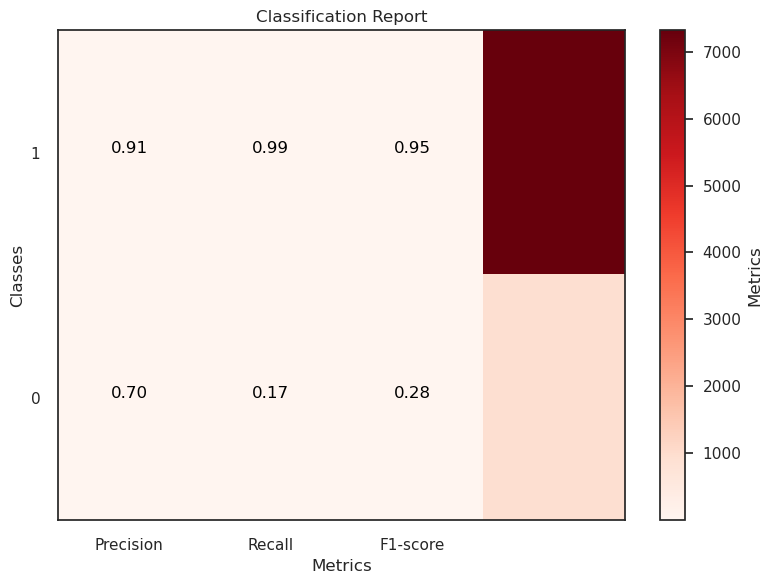

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import itertools

# Compute predictions
predictions = model.transform(testData)

# Extract true labels and predicted labels
y_true = predictions.select(label_column).rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

predictions.write.format('delta').mode("overwrite").save('Tables/retail_banking_churn_prediction')

# Get classes
classes = predictions.select(label_column).distinct().rdd.flatMap(lambda x: x).collect()

# Compute classification report
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

# Define custom colormap for heatmap-like colors
cmap = plt.cm.Reds

# Plot classification report
plt.figure(figsize=(8, 6))
plt.grid(False)
plt.imshow([[report[label][metric] for metric in report[label]] for label in classes], interpolation='nearest', cmap=cmap, aspect='auto')
plt.title('Classification Report')
plt.colorbar(label='Metrics')
plt.xticks(np.arange(3), ['Precision', 'Recall', 'F1-score'])
plt.yticks(np.arange(len(classes)), classes)

fmt = '.2f'
thresh = (np.max([[report[label][metric] for metric in report[label]] for label in classes]) + np.min([[report[label][metric] for metric in report[label]] for label in classes])) / 2
for i, j in itertools.product(range(len(classes)), range(3)):
    plt.text(j, i, format([[report[label][metric] for metric in report[label]] for label in classes][i][j], fmt),
            horizontalalignment="center",
            color="white" if [[report[label][metric] for metric in report[label]] for label in classes][i][j] > thresh else "black")

plt.ylabel('Classes')
plt.xlabel('Metrics')
plt.tight_layout()
plt.show()


StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 33, Finished, Available, Finished)

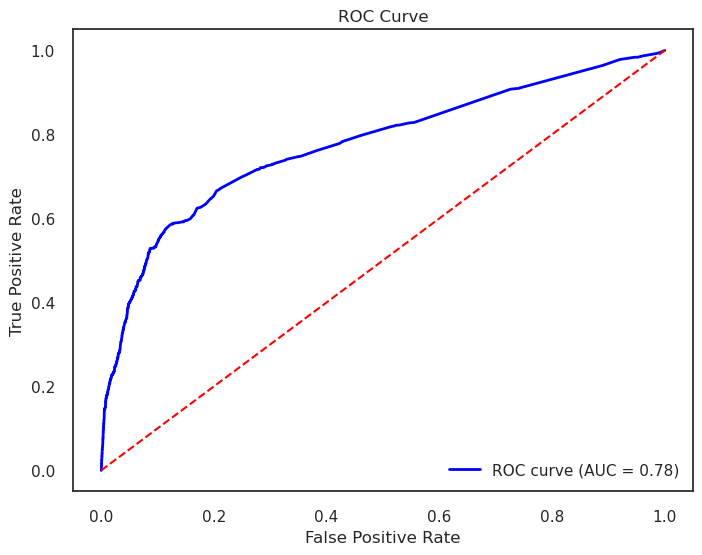

ROC AUC: 0.7750091000729045


In [31]:
# Get probability predictions for the positive class
probabilities = predictions.select("probability").rdd.map(lambda row: row.probability[1])
# Get true labels for the test data
labels = predictions.select("churn").rdd.map(lambda row: row.churn)

# Compute ROC curve
fpr, tpr, _ = roc_curve(labels.collect(), probabilities.collect())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print("ROC AUC:", roc_auc)

In [ ]:
df = spark.sql("SELECT * FROM #LAKEHOUSE_SILVER#.banking_churn_prediction")
display(df)

StatementMeta(, 774b141f-9248-4426-83e7-f65b986fee58, 34, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 05d43965-d8c4-4c20-a0e0-0bc1e3c15a66)